# HBR transfer example

Welcome to this example/tutorial notebook that will go through the fitting, evaluation, and transfering of HBR models. 

### Imports

In [1]:
# Need to install graphviz for the graphical model visualization
# %conda install -c conda-forge python-graphviz graphviz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.normative_model.norm_factory import load_normative_model
from pcntoolkit.normative_model.norm_factory import create_normative_model
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf
from pcntoolkit.regression_model.hbr.param import Param
from pcntoolkit.regression_model.hbr.hbr import HBR
from pcntoolkit.util.plotter import plot_centiles, plot_qq
import seaborn as sns
import arviz as az
import os

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [3]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line
pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)

In [4]:
data = pd.read_csv("resources/data/fcon1000.csv")

Plot the distribution of sex and site in the data.

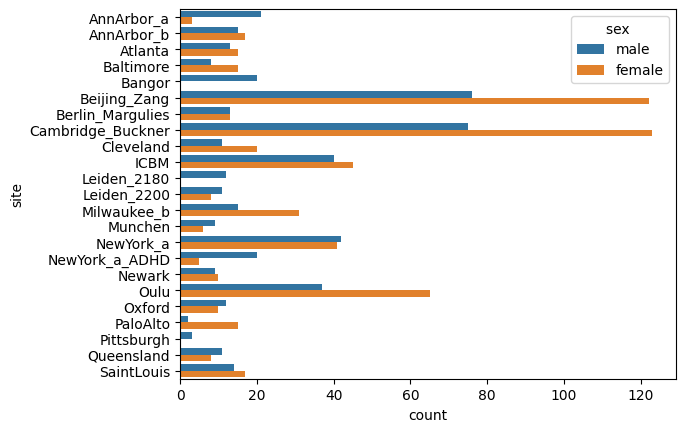

In [5]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()

Our HBR models will use random effects to model differences between sites. Because the random effects are best captured when there are enough samples of each effect in the data, we will have to remove some sites that are too small. We will filter out sites for which any of the sexes is represented by less than 10 samples

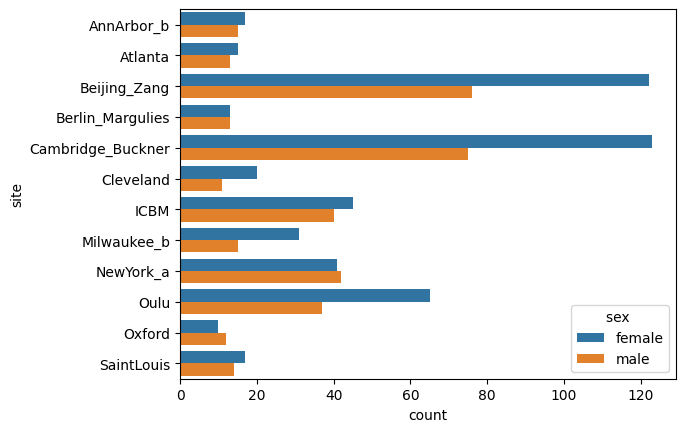

In [6]:
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")  # type: ignore
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index
data = data[~data["site"].isin(sites_with_one_sex.index)]
site_counts = site_counts[site_counts["counts"] < 10]
data = data[~data["site"].isin(site_counts["site"])]
sns.countplot(data=data, y="site", hue="sex ", orient="v")
plt.show()


Now we load the data into a `NormData` object. 

In [7]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

We will use 2 sites for transfer (Milwaukee and Oulu) and the rest for training.

In [8]:
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects(
    {"site": transfer_sites}, names=["transfer", "fit"]
)


We also split the data into train and test sets.

In [9]:
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [10]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Configuration of normative model is valid.


## Configure the regression model

HBR models need to specificy (possibly recursive) parameter configurations. Here, we configure a HBR model with a SHASHb likelihood, a bspline regression in `mu` and `sigma`, and a random effect in the intercept of `mu`. Note that because sigma has to be strictly positive, we specify a `softplus` mapping, so that the output of the linear regression is mapped to the positive domain. 

In [11]:
mu = Param(
    name="mu",
    linear=True,
    slope=Param(dist_name="Normal", dist_params=(0.0, 10.0)),
    intercept=Param(
        random=True,
        centered=False,
        mu=Param(dist_name="Normal", dist_params=(0.0, 1.0)),
        sigma=Param(dist_name="HalfCauchy", dist_params=(1.0,)),
    ),
)
sigma = Param(
    name="sigma",
    linear=True,
    slope=Param(dist_params=(0.0, 5.0)),
    intercept=Param(dist_name="Normal", dist_params=(1.0, 2.0)),
    mapping="softplus",
    mapping_params=(0.0, 5.0),
)
epsilon = Param(
    name="epsilon",
    linear=False,
    dist_name="Normal",
    dist_params=(0, 10.0),
)
delta = Param(
    name="delta",
    linear=False,
    dist_name="Normal",
    dist_params=(0.0, 3.0),
    mapping="softplus",
    mapping_params=(0.0, 5.0, 0.3),
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=1500,
    tune=500,
    chains=4,
    pymc_cores=16,
    likelihood="SHASHo",
    mu=mu,
    sigma=sigma,
    epsilon=epsilon,
    delta=delta,
    nuts_sampler="nutpie",
    init="jitter+adapt_diag",
)

## Combine normative and hbr conf in normative model
We can either use the NormHBR constructor, or the factory method to create a normative HBR model

In [12]:
# Using the constructor
norm_hbr = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
display(norm_hbr)
del norm_hbr

In [13]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, hbr_conf)
norm_hbr

## Fit the model
With all our configuration done, we can fit our model on the train data. 

In [14]:
predictions = norm_hbr.fit_predict(train, test)

Going to fit and predict 2 models
Fitting and predicting model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.18,31
,2000,0,0.18,63
,2000,0,0.17,63
,2000,0,0.18,127


Sampling: [y_pred]


Output()

Fitting and predicting model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,63
,2000,0,0.12,31
,2000,0,0.10,63
,2000,0,0.13,63


Sampling: [y_pred]


Output()

99858 Saving model to resources/hbr/save_dir


Sampling: [y_pred]


Output()

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/model
Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir/plots


As we can see, the model is saved to the save_dir specified in the norm_conf. We can inspect that folder to find three subfolders:
- `model`: contains the model and metadata
- `results`: containing csv files with the evaluation results for all response variables
- `plots`: containing qq plots and centile plots for each response variable

## Inspecting the model 

The norm_hbr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_hbr.regression_models.get("{responsevar}")`

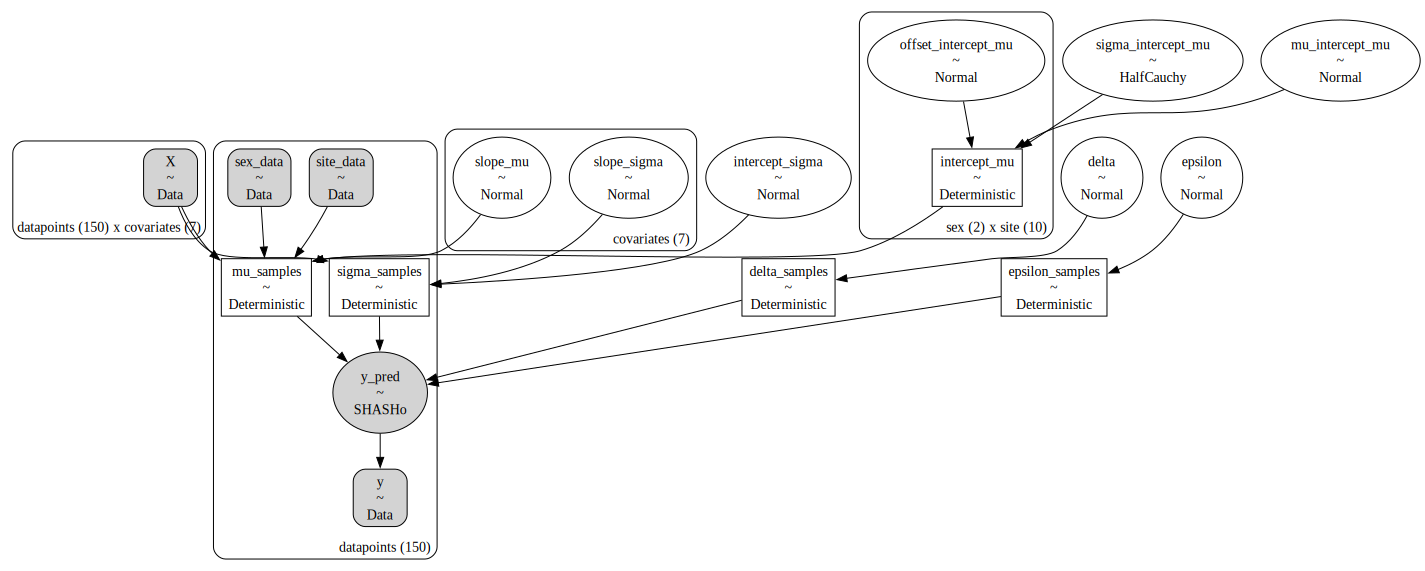

In [15]:
model: HBR = norm_hbr.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
model.pymc_model.to_graphviz()  # type: ignore

We can use the arviz library to inspect the posterior samples (trace) of the model. Here we only use the 'plot_trace' function to inspect the trace of the model, but there are many other useful functions available. If you are not familiar with arviz, we recommend checking out the [arviz documentation](https://arviz-devs.github.io/arviz/index.html).


<Figure size 640x480 with 0 Axes>

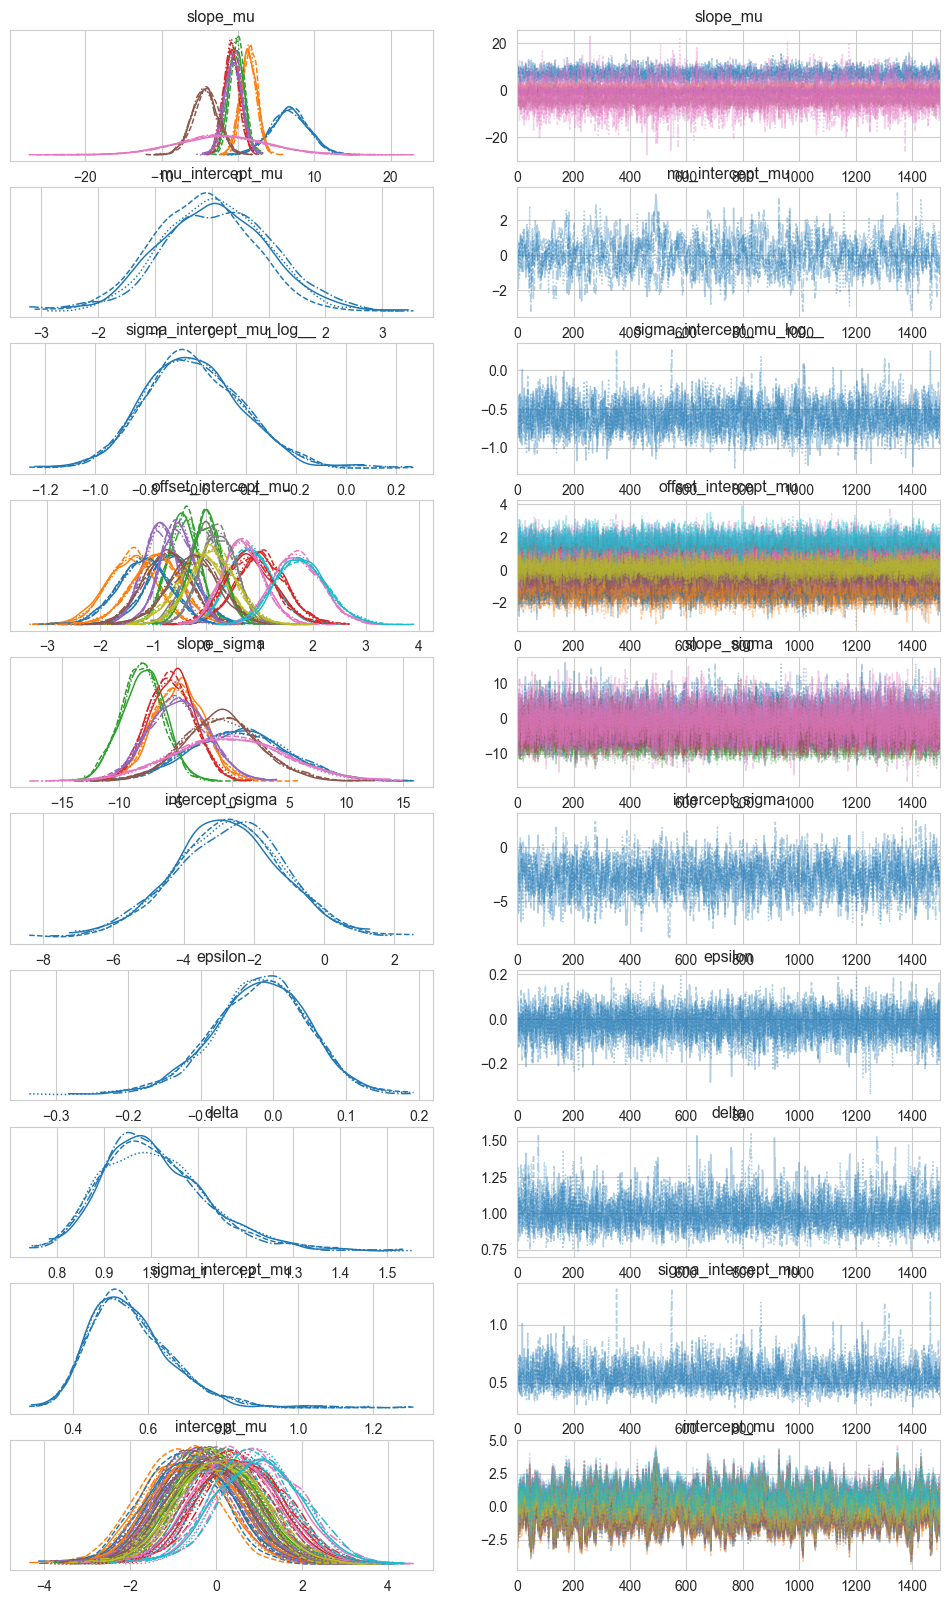

In [16]:
idata = model.idata  # type: ignore

plt.tight_layout()
az.plot_trace(idata.posterior, var_names="~_samples", filter_vars="like")
plt.show()

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [17]:
display(test.measures.to_pandas().T)


response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.512873,0.499817
RMSE,0.076439,460.521115
SMSE,0.600639,0.650295
ExpV,0.400122,0.358903
NLL,NaN,NaN
ShapiroW,0.992090,0.980463


Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [18]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
124,0.682524,1.045770
48,-0.362898,-0.784775
545,0.698413,0.243849
847,1.137779,0.689831
360,-2.232968,-0.038168
...,...,...
688,-1.191463,0.402035
420,0.736100,0.850615
123,-0.963421,-1.327064


In [19]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
124                             2.370770         601.228875   
48                              2.320913         522.864089   
545                             2.287611         752.300096   
847                             2.363885         720.359562   
360                             2.364573         905.332764   
...                                  ...                ...   
688                             2.333361         652.541485   
420                             2.380920         878.334969   
123                             2.404389         690.998424   
276                             2.408594         439.703014   
183                             2.382092         609.119366   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
124                             2.436660         784.116487   
48                              2.386803         705.751702   
545                             2.379016        1254.864008   
847                             2.428340         912.350527   
360                             2.430463        1088.220376   
...                                  ...                ...   
688                             2.400174         856.321970   
420                             2.453712        1066.057358   
123                             2.472244         873.469237   
276                             2.472762         628.250674   
183                             2.449947         791.590180   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
124                             2.482018         937.843328   
48                              2.432161         859.478542   
545                             2.441991        1677.207020   
847                             2.472701        1073.759501   
360                             2.475821        1241.947217   
...                                  ...                ...   
688                             2.446160        1027.640212   
420                             2.503835        1223.795728   
123                             2.518961        1026.828456   
276                             2.516927         786.761001   
183                             2.496664         944.949399   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
124                             2.526964        1188.665611   
48                              2.477107        1110.300826   
545                             2.504411        2365.687385   
847                             2.516658        1337.022995   
360                             2.520767        1492.769500   
...                                  ...                ...   
688                             2.491722        1307.013877   
420                             2.553494        1481.228944   
123                             2.565252        1277.078679   
276                             2.560690        1045.320466   
183                             2.542955        1195.199621   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


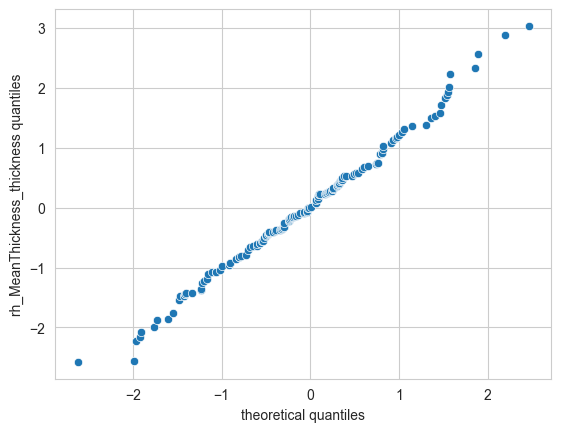

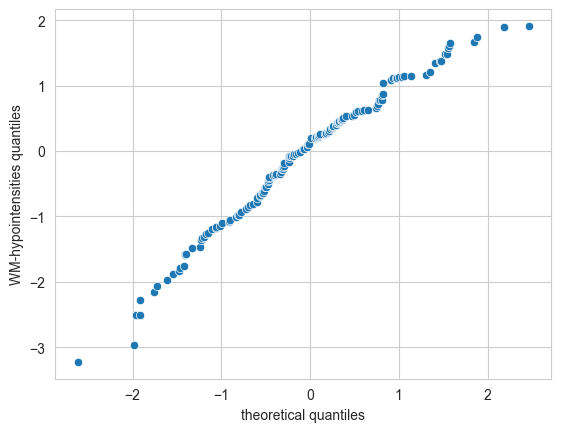

In [20]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


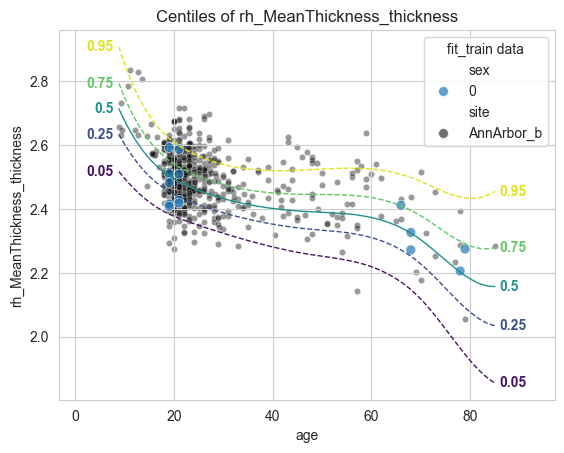

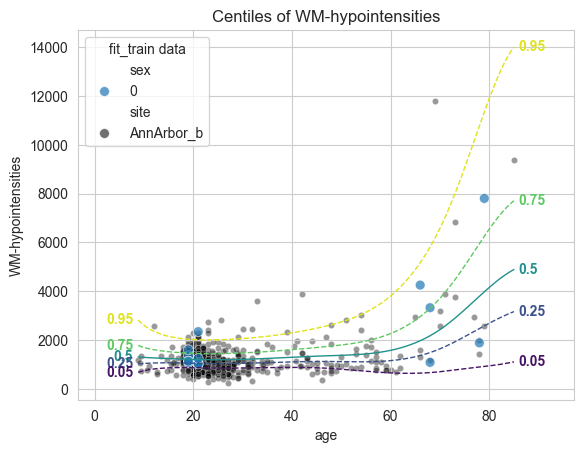

In [21]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


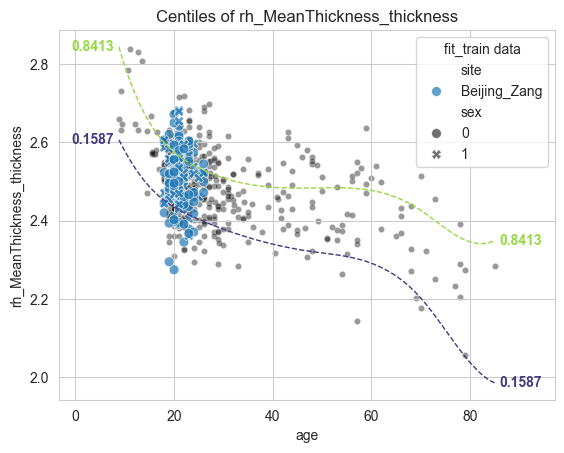

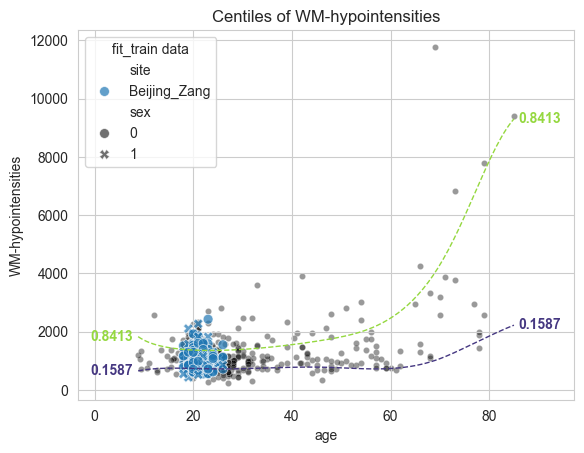

In [22]:
plot_centiles(
    norm_hbr,
    train,
    covariate="age",
    cummul_densities=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

## Transfer

We transfer the model to the transfer_train dataset that we created before. The posterior distribution is factorized and a new RegConf is created using the factorized posterior as a prior. To give some extra control, we let the `freedom` parameter control the variance of the derived factorized posterior. With a `freedom` of 1, the factorized representation is used as is. With freedom of `2`, all derived prior distributions are widened by a factor of 2. 

In [23]:
transfered_model = norm_hbr.transfer(
    transfer_train, freedom=0.0001, nuts_sampler="nutpie"
)
# Caused by:
#     Logp function returned error: Logp function returned error code 4

Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.72,7
,2000,0,0.72,7
,2000,0,0.75,7
,2000,0,0.72,7


Transferring model for WM-hypointensities


Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.74,7
,2000,0,0.73,7
,2000,0,0.73,3
,2000,0,0.70,7


Configuration of normative model is valid.
99858 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


We can save, load, predict, and plot just as before. 

If the orinal save directory path was `{path}/{save_dir}`, then the transfered model's save directory path will be `{path}/{save_dir}_tansfer`, and the same holds for the log dir path

In [24]:
transfered_model.save()

99858 Saving model to resources/hbr/save_dir_transfer
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/model


In [25]:
os.makedirs("resources/save_dir_transfer", exist_ok=True)

In [27]:
transfered_model = load_normative_model("resources/hbr/save_dir_transfer")
transfered_predictions = transfered_model.predict(transfer_test)

Sampling: [y_pred]


Output()

Configuration of normative model is valid.
Configuration of normative model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing zscores for WM-hypointensities


Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


/opt/anaconda3/envs/ptk_dev/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr/save_dir_transfer/plots


In [28]:
display(transfered_predictions.measures.to_pandas().T)
display(transfered_predictions.zscores.to_pandas())
display(
    transfered_predictions.centiles.to_dataframe().unstack(
        level=["response_vars", "cdf"]
    )
)

response_vars,rh_MeanThickness_thickness,WM-hypointensities
statistics,,
Rho,0.681933,0.059621
RMSE,0.063575,472.010606
SMSE,0.534727,1.069265
ExpV,0.476520,-0.062067
NLL,NaN,NaN
ShapiroW,0.966827,0.964547


response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
794,-0.539785,0.032713
796,0.197502,-0.192953
758,-0.014551,0.419592
786,2.184659,0.101599
746,-1.131933,-0.760299
749,0.097719,-0.458075
802,-0.841642,-1.216903
812,0.346389,-0.644105
730,-0.547478,-0.435578


centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
794                             2.389418         552.833264   
796                             2.389418         552.832998   
758                             2.399161         796.840636   
786                             2.389418         552.833730   
746                             2.399161         796.840903   
749                             2.389418         552.832998   
802                             2.389418         552.832998   
812                             2.389418         552.832998   
730                             2.399161         796.840636   
640                             2.292475         646.850483   
607                             2.261814         459.366474   
731                             2.389418         552.832998   
641                             2.261814         459.363127   
750                             2.389418         552.832998   
638                             2.292475         646.846919   
619                             2.261814         459.367864   
826                             2.389418         552.833264   
808                             2.389418         552.833264   
740                             2.399161         796.840903   
626                             2.261814         459.364030   
807                             2.389418         552.833264   
800                             2.399161         796.840903   
608                             2.261814         459.363365   
613                             2.261814         459.368277   
774                             2.389418         552.832998   
599                             2.292475         646.849843   
747                             2.399161         796.840903   
816                             2.399161         796.840636   
751                             2.399161         796.840903   
819                             2.389418         552.833264   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
794                             2.469885         924.621768   
796                             2.469885         924.621430   
758                             2.479628        1168.629068   
786                             2.469885         924.622321   
746                             2.479628        1168.629406   
749                             2.469885         924.621430   
802                             2.469885         924.621430   
812                             2.469885         924.621430   
730                             2.479628        1168.629068   
640                             2.372942        1018.638604   
607                             2.342281         831.154823   
731                             2.469885         924.621430   
641                             2.342281         831.151690   
750                             2.469885         924.621430   
638                             2.372942        1018.635306   
619                             2.342281         831.156068   
826                             2.469885         924.621768   
808                             2.469885         924.621768   
740                             2.479628        1168.629406   
626                             2.342281         831.152410   
807                             2.469885         924.621768   
800                             2.479628        1168.629406   
608                             2.342281         831.151849   
613                             2.342281         831.156398   
774                             2.469885         924.621430   
599                             2.372942        1018.638079   

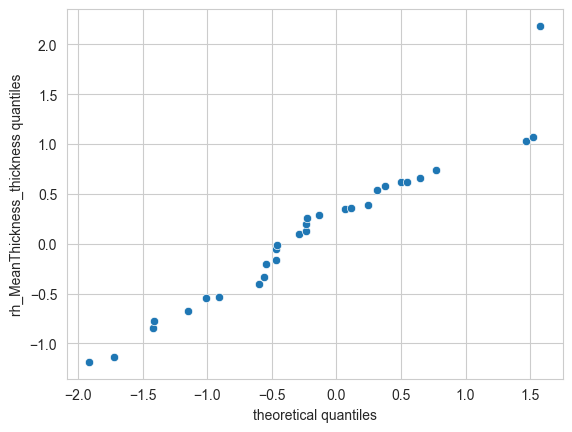

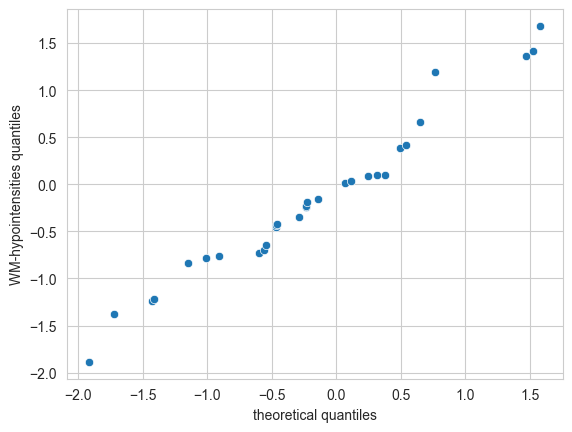

In [29]:
plot_qq(transfer_test)

Sampling: [y_pred]


Output()

Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Computing centiles for WM-hypointensities


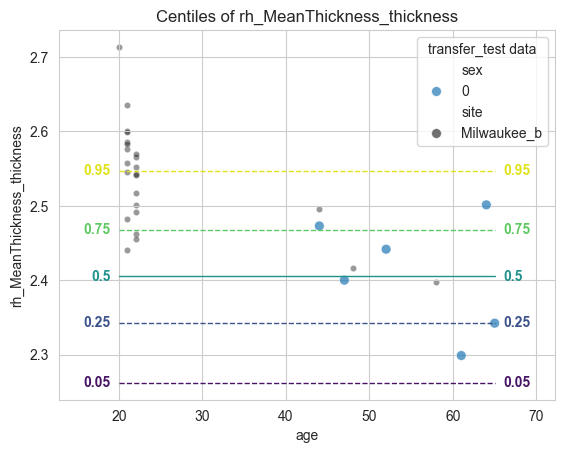

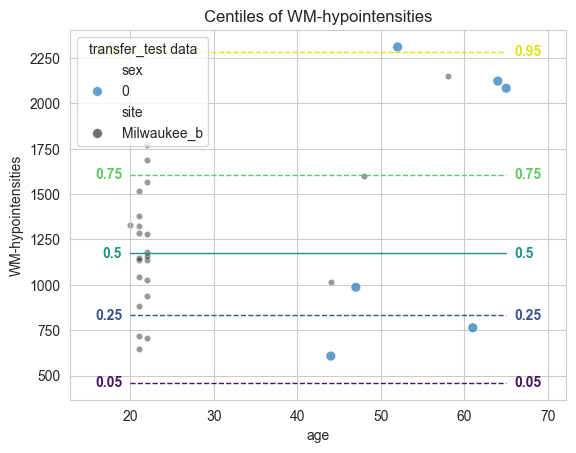

In [30]:
plot_centiles(
    transfered_model,
    transfer_test,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

And that's it, now you have seen how to:
- Use the NormData class to load in your data
- Create and fit a normative model
- Get the evaluation statistics, and create some useful plots
- Transfer the model to another dataset

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!